<img src="resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Visual Behavior Neuropixels Workshop SWDB 2022 </h1> 
<h3 align="center">Tuesday, August 23rd, 2022</h3> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>This notebook will introduce you to the Visual Behavior Neuropixels dataset and associated AllenSDK functions. 
    
<p>The introduction is centered around a set of scientific questions: 

### How does image novelty impact: 
    
1) <a href='#How-does-novelty-impact-visual-responsiveness?'>Visual responses in visual cortex</a>
* <a href='#Accessing-the-Dataset'>Accessing the Dataset</a>
* <a href='#Filtering-the-sessions-table-for-a-session-of-interest'>Filtering the sessions table for a session of interest</a>
* <a href='#Understanding-the-session-object'>Understanding the session object</a>
* <a href='#Plotting-receptive-fields'>Plotting receptive fields</a>
* <a href='#Plotting-visual-responses-to-novel-and-familiar-images'>Plotting visual responses to novel and familiar images</a>
* <a href='#Using-Optotagging-to-Identify-SST-Neurons'>Using Optotagging to Identify SST Neurons</a>
    
2) <a href='#How-does-novelty-impact-mouse-behavior?'>Behavior during the Detection of Change task
* <a href='#Understanding-the-trials-table'>Understanding the trials table</a>
* <a href='#Calculating-hit-rates-for-novel-and-familiar-images'>Calculating hit rates for novel and familiar images</a>
* <a href='#Getting-pupil,-running-and-licking-data'>Getting pupil, running and licking data</a>
* <a href='#Aligning-behavioral-data-to-task-events'>Aligning behavioral data to task events</a>



In [83]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import scipy.ndimage as ndi
from matplotlib.gridspec import GridSpec
from scipy.stats import binomtest
from matplotlib import cm

%matplotlib inline

# How does novelty impact visual responsiveness?

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
## Accessing the Dataset
    
<p>To answer our questions, we first need to access the data. The main entry point to the VBN dataset is the `VisualBehaviorNeuropixelsProjectCache` class.  This class is responsible for downloading any requested data or metadata as needed and storing it in well known locations.  For this workshop, all of the data has been preloaded onto the hard drives you have received, and is available on AWS.

<p>We begin by specifying our data cache directory. Then we'll import the `VisualBehaviorNeuropixelsProjectCache` class and instantiate it.


In [3]:
import platform
platstring = platform.platform()

if 'Darwin' in platstring:
    # macOS 
    data_root = "/Volumes/Brain2022/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn1' in platstring):
    # then on AWS
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2022/"

In [2]:
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

C:\Users\svc_ccg\AppData\Local\Continuum\anaconda3\envs\allensdk_38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# this path should point to the location of the dataset on your platform
#cache_dir = r"/Volumes/programs/mindscope/workgroups/np-behavior/vbn_data_release/vbn_s3_cache"
cache_dir = r"\\allen\programs\mindscope\workgroups\np-behavior\vbn_data_release\vbn_s3_cache"

cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(
            cache_dir=cache_dir)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

The data manifest is comprised of 5 types of tables: 

1. `ecephys_sessions_table` (64 kB)
2. `behavior_sessions_table` (531 kB)
3. `units_table` (130 MB)
4. `probes_table` (127 kB)
5. `channels_table` (28 MB)

The `ecephys_sessions_table` contains metadata for every <b>Neuropixels recording session</b> in the dataset. We attempted to insert 6 probes for each experiment, but occasionally individual insertions failed. The `probe_count` column tells you how many probes were inserted for a given session. The `structure_acronyms` column indicates which brain areas were targeted. For the majority of mice, there are two recording sessions. These were run on consecutive days with two different image sets, `G` and `H`. The `experience_level` column tells you whether the image set used for a particular recording was the same as the training image set (`Familiar`), or different from the training image set (`Novel`).

The `behavior_sessions_table` contains metadata for each behavior session. Some behavior sessions have Neuropixels data associated with them, while others took place during training in the behavior facility. The different training stages that mice progressed through are described by the `session_type`. 

The `units_table` contains metadata for every unit in the release. Each unit can be linked to the corresponding recording session, probe and channel by the `ecephys_session_id`, `ecephys_probe_id` and `ecephys_channel_id` columns. This table also contains a number of helpful quality metrics, which can be used to filter out contaminated units before analysis. For more guidance on how to use these metrics, check out [this tutorial](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/visual_behavior_neuropixels_quality_metrics.html).

The `probes_table` contains metadata for each probe insertion.

The `channels_table` contains metadata for each channel recorded during an ephys session. This table provides useful info about where a particular channel is located in the Allen Common Coordinate Framework as well as it's relative position on the probe.

Now let's look at a few of these tables in more detail to get a better sense of the dataset.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
## Filtering the sessions table for a session of interest
    
<p>Now let's grab the sessions table from the cache and take a look at what information it provides.

In [8]:
ecephys_sessions_table = cache.get_ecephys_session_table()
ecephys_sessions_table.head()

,behavior_session_id,date_of_acquisition,equipment_name,session_type,mouse_id,genotype,sex,project_code,age_in_days,unit_count,...,channel_count,structure_acronyms,image_set,prior_exposures_to_image_set,session_number,experience_level,prior_exposures_to_omissions,file_id,abnormal_histology,abnormal_activity
ecephys_session_id,,,,,,,,,,,,,,,,,,,,,
1052342277,1052374521,2020-09-23 15:34:18.179,NP.1,EPHYS_1_images_G_3uL_reward,530862,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,148,1696.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,32.0,1,Familiar,0.0,0,NaN,NaN
1051155866,1052162536,2020-09-17 15:05:39.665,NP.1,EPHYS_1_images_H_3uL_reward,524760,wt/wt,F,NeuropixelVisualBehavior,180,1922.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,1,NaN,NaN
1052533639,1052572359,2020-09-24 15:12:13.229,NP.1,EPHYS_1_images_H_3uL_reward,530862,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,149,1677.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,4,NaN,NaN
1053925378,1053960984,2020-10-01 16:07:18.990,NP.0,EPHYS_1_images_H_3uL_reward,532246,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,145,1823.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,5,NaN,NaN
1053941483,1053960987,2020-10-01 17:03:58.362,NP.1,EPHYS_1_images_H_3uL_reward,527749,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,180,1543.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,6,NaN,NaN


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

This table gives us lots of useful metadata about each recording session, including when the session took place, the genotype, sex and age of the mouse that was run, what brain areas were recorded and some important info about the stimulus. 

To demystify a few of these columns, let's briefly review the experimental design. Each mouse was trained with one of two image sets (`G` or `H`). For the majority of mice, we recorded two sessions: one with the trained `Familiar` image set and one with a `Novel` image set. Note that two of the eight images were shared across these two image sets as diagrammed below for an example mouse that was trained with image set `G`. 

<div>
<img src="https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/38/65/3865999b-e8c4-4b2d-bead-2bb385448a8d/gh_diagram.png", width="900"/>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

So, each recording session can be defined by a few parameters, including the `image_set` used (`G` or `H`), the `experience_level` of the mouse (indicating whether the mouse had seen the image set in previous training sessions) and the `session_number` (indicating whether it was the first or second recording day for the mouse). Let's look at how many sessions we have of each type:

In [9]:
sessions_by_imageset_experience_day = ecephys_sessions_table.pivot_table(index=['session_number', 'experience_level'], #rows of our pivot table
                                                                         columns=['image_set'], #columns of pivot table                                                                         
                                                                         values='behavior_session_id', #column of dataframe to run aggfunc on
                                                                         aggfunc=len) #function to apply to 'values' to fill out pivot table

display(sessions_by_imageset_experience_day)

image_set                           G     H
session_number experience_level            
1              Familiar          38.0  10.0
               Novel              NaN   3.0
2              Familiar           3.0   NaN
               Novel             10.0  39.0

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

In addition to different types of image sets, this dataset contains ephys recording sessions from 3 genotypes (C57BL6J, VIP-IRES-CrexAi32 and SST-IRES-CrexAi32). 

For this tutorial, we need to select a session with:
- `Novel` images presented
- `Sst-IRES-Cre` mouse

In [10]:
sst_novel_sessions = ecephys_sessions_table.loc[(ecephys_sessions_table['genotype'].str.contains('Sst')) & 
                                            (ecephys_sessions_table['experience_level']=='Novel')]
sst_novel_sessions.head()

,behavior_session_id,date_of_acquisition,equipment_name,session_type,mouse_id,genotype,sex,project_code,age_in_days,unit_count,...,channel_count,structure_acronyms,image_set,prior_exposures_to_image_set,session_number,experience_level,prior_exposures_to_omissions,file_id,abnormal_histology,abnormal_activity
ecephys_session_id,,,,,,,,,,,,,,,,,,,,,
1053941483,1053960987,2020-10-01 17:03:58.362,NP.1,EPHYS_1_images_H_3uL_reward,527749,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,180,1543.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,6,NaN,NaN
1064644573,1064666428,2020-11-19 15:18:01.372,NP.1,EPHYS_1_images_H_3uL_reward,544456,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,120,2254.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,27,NaN,NaN
1048189115,1048221709,2020-09-03 14:16:57.913,NP.1,EPHYS_1_images_H_3uL_reward,509808,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,264,1925.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,37,NaN,NaN
1048196054,1048222325,2020-09-03 14:25:07.290,NP.0,EPHYS_1_images_H_3uL_reward,524925,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,F,NeuropixelVisualBehavior,166,2288.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,38,NaN,NaN
1065905010,1065929713,2020-11-24 14:21:48.847,NP.0,EPHYS_1_images_H_3uL_reward,544358,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,F,NeuropixelVisualBehavior,126,1998.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,39,NaN,NaN


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Understanding the session object

All data from a particular recording session is contained in the `ecephys_session` object. Let's load one of our novel, SST sessions:

In [7]:
session_id = 1053941483
session = cache.get_ecephys_session(
            ecephys_session_id=session_id)

C:\Users\svc_ccg\AppData\Local\Continuum\anaconda3\envs\allensdk_38\lib\site-packages\hdmf\utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We can get a high-level summary of this session by accessing its `metadata` attribute:

In [11]:
session.metadata

{'equipment_name': 'NP.1',
 'sex': 'M',
 'age_in_days': 180,
 'stimulus_frame_rate': 60.0,
 'session_type': 'EPHYS_1_images_H_3uL_reward',
 'date_of_acquisition': datetime.datetime(2020, 10, 2, 0, 3, 58, tzinfo=tzutc()),
 'reporter_line': 'Ai32(RCL-ChR2(H134R)_EYFP)',
 'cre_line': 'Sst-IRES-Cre',
 'behavior_session_uuid': None,
 'driver_line': ['Sst-IRES-Cre'],
 'mouse_id': 527749,
 'full_genotype': 'Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt',
 'behavior_session_id': 1053960987,
 'ecephys_session_id': 1053941483}

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Stimulus presentations

The first step to analyzing how the mouse and its neurons responded to various stimuli is to understand which stimuli were presented at what time. For this, we use the stimulus presentations table.

Every recording session consisted of three major visual stimulus epochs in the following order (diagrammed below):
- An active behavior session during which the mouse performed the change detection task
- Receptive field mapping and full-field flash stimuli
- 'Passive' replay of stimulus shown during active behavior, but without the lickspout so the mouse can no longer respond.

<div>
<img src="https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public_thumbnails/filer_public/65/58/6558f0eb-c3c5-45e6-b645-b2e432200804/active_passive_diagram.png__710x291_q90_subsampling-2.png", width="900"/>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Let's look at the stimulus presentations table for the session we already loaded

In [12]:
stimulus_presentations = session.stimulus_presentations
stimulus_presentations.head()

,active,color,contrast,duration,end_frame,flashes_since_change,image_name,is_change,omitted,orientation,...,position_y,rewarded,spatial_frequency,start_frame,start_time,stimulus_block,stimulus_index,stimulus_name,stop_time,temporal_frequency
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,,,
0,True,NaN,NaN,0.250212,75,0.0,im104_r,False,False,NaN,...,NaN,False,NaN,60,25.254420,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,25.504632,NaN
1,True,NaN,NaN,0.250212,120,1.0,im104_r,False,False,NaN,...,NaN,False,NaN,105,26.005057,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,26.255269,NaN
2,True,NaN,NaN,0.250208,165,2.0,im104_r,False,False,NaN,...,NaN,False,NaN,150,26.755685,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,27.005892,NaN
3,True,NaN,NaN,0.250207,210,3.0,im104_r,False,False,NaN,...,NaN,False,NaN,195,27.506307,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,27.756515,NaN
4,True,NaN,NaN,0.250213,255,4.0,im104_r,False,False,NaN,...,NaN,False,NaN,240,28.256929,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,28.507142,NaN


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

This table is a record of every stimulus we presented to the mouse over the course of this experiment. The different stimuli are indexed by the `stimulus_block` column. Let's group this dataframe by stimulus block and see what stimulus was shown for each block.

In [14]:
stimulus_presentations.groupby('stimulus_block')[['stimulus_block', 'stimulus_name', 'active', 'duration']].head(1)

,stimulus_block,stimulus_name,active,duration
stimulus_presentations_id,,,,
0,0,Natural_Images_Lum_Matched_set_ophys_H_2019,True,0.250212
4804,1,spontaneous,False,10.008400
4805,2,gabor_20_deg_250ms,False,0.250213
8450,3,spontaneous,False,288.991867
8451,4,flash_250ms,False,0.250213
8601,5,Natural_Images_Lum_Matched_set_ophys_H_2019,False,0.250201


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

This shows us the structure of this experiment (and every experiment in this dataset). There are 5 stimuli as follows:

**block 0**: Change detection task. Natural images are flashed repeatedly and the mouse is rewarded for licking when the identity of the image changes. You can find more info about this task [here](http://portal.brain-map.org/explore/circuits/visual-behavior-neuropixels?edit&language=en).

**block 1**: Brief gray screen

**block 2**: Receptive field mapping using gabor stimuli. For more details on this stimulus consult [this notebook](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_receptive_fields.html).

**block 3**: Longer gray screen

**block 4**: Full-field flashes, shown at 80% contrast. Flashes can be black (color = -1) or white (color = 1).

**block 5**: Passive replay. Frame-for-frame replay of the stimulus shown during the change detection task (block 0), but now with the lick spout retracted so the animal can no longer engage in the task.

    
For now, we will focus on block 0 and 5, the active behavior and the passive replay of the same images.

Let's confirm that the active behavior block (0) and the passive replay block (5) match frame for frame:

In [84]:
active_image_presentations = stimulus_presentations[stimulus_presentations['stimulus_block']==0]
passive_image_presentations = stimulus_presentations[stimulus_presentations['stimulus_block']==5]
np.all(active_image_presentations['image_name'].values == passive_image_presentations['image_name'].values)

True

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Units and channels tables

We'll use the units and channels tables to get info about each unit recorded during the session. These tables will help us filter the data for units in a particular brain region or for units that meet specific quality criteria.

### Units table

In [85]:
units = session.get_units()
units.head()

,PT_ratio,amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,l_ratio,...,presence_ratio,quality,recovery_slope,repolarization_slope,silhouette_score,snr,spread,velocity_above,velocity_below,waveform_duration
id,,,,,,,,,,,,,,,,,,,,,
1061853767,0.738222,632.394165,0.000008,23,79.63,10.843623,68.687706,0.000167,246.203332,3.104812e-08,...,0.99,good,-0.808696,2.795432,0.113092,4.519657,60.0,0.686767,0.137353,0.206030
1061853941,0.490965,207.990510,0.273518,196,347.89,3.966892,1.747814,0.374140,60.672055,3.726235e-03,...,0.99,good,-0.112609,0.618665,0.099188,2.541619,70.0,0.480737,0.206030,0.618090
1061853761,0.538560,284.645010,0.475406,17,188.14,4.841153,5.819598,0.010472,74.209946,8.290955e-04,...,0.99,good,-0.312478,1.265120,0.093662,2.558605,60.0,0.343384,-1.098827,0.233501
1061853892,2.714716,180.353940,0.500000,147,1289.78,6.065760,2.396936,0.157757,88.232357,5.768766e-04,...,0.99,good,-0.066549,0.654593,0.051338,2.419777,40.0,-0.343384,-0.686767,0.425796
1061853891,1.105938,533.637585,0.000136,146,474.71,8.037788,2.563054,0.000000,147.532935,7.581718e-08,...,0.99,good,-1.241809,1.728842,0.159304,5.942894,50.0,-0.068677,0.686767,0.151089


### Channels Table

In [17]:
channels = session.get_channels()
channels.head(3)

,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,filtering,left_right_ccf_coordinate,probe_channel_number,probe_horizontal_position,probe_id,probe_vertical_position,structure_acronym
id,,,,,,,,,
1061851368,8315.0,4024.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,6882.0,0,43,1054059289,20,APN
1061851369,8313.0,4014.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,6886.0,1,11,1054059289,20,APN
1061851370,8311.0,4004.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,6889.0,2,59,1054059289,40,APN


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Because we will want to use info from both tables to filter our units, we can merge them into one table with all of the relevant columns. This merged table will include quality metrics and CCF locations for every unit. For example, we can use it to see which brain regions were recorded during this session:

In [18]:
units = units.merge(channels, left_on='peak_channel_id', right_index=True)
units.value_counts('structure_acronym')

structure_acronym
CA1      269
APN      170
VISpm    135
POL      109
VISal     84
LP        75
VISp      75
VISrl     74
DG        72
MGv       70
VISl      69
CA3       67
VISam     60
SUB       34
LGv       34
ZI        30
PIL       27
MRN       25
MB        21
TH        13
MGm        8
MGd        8
PoT        6
SGN        5
DT         3
dtype: int64

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

For more information about many of the metrics included in this table and how to use them to guide your analysis, see our [quality metrics tutorial](https://allensdk--2471.org.readthedocs.build/en/2471/_static/examples/nb/visual_behavior_neuropixels_quality_metrics.html). For now, here's a brief description of each column:


**General Metadata**  

`anterior_posterior_ccf_coordinate`:    CCF coord in the AP axis  
`dorsal_ventral_ccf_coordinate`:        CCF coord in the DV axis
`left_right_ccf_coordinate`:            CCF coord in the left/right axis  
`structure_acronym`:                    CCF acronym for area to which unit was assigned  
`structure_id`:                         CCF structure ID for the area to which unit was assigned  
`probe_horizontal_position`:            Horizontal (perpindicular to shank) probe position of each unit's peak channel in microns  
`probe_vertical_position`:              Vertical (along shank) probe position of each unit's peak channel in microns


**Waveform metrics**: Look [here](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) for more detail on these metrics and the code that computes them. For the below descriptions the '1D waveform' is defined as the waveform on the peak channel. The '2D waveform' is the waveform across channels centered on the peak channel.

`amplitude`:                            Peak to trough amplitude for mean 1D waveform in microvolts   
`waveform_duration`:                    Time from trough to peak for 1D waveform in milliseconds     
`waveform_halfwidth`:                   Width of 1D waveform at half-amplitude in milliseconds  
`PT_ratio`:                             Ratio of the max (peak) to the min (trough) amplitudes for 1D waveform  
`recovery_slope`:                       Slope of recovery of 1D waveform to baseline after repolarization (coming down from peak)  
`repolarization_slope`:                 Slope of repolarization of 1D waveform to baseline after trough  
`spread`:                               Range of channels for which the spike amplitude was above 12% of the peak channel amplitude  
`velocity_above`:                       Slope of spike propagation velocity traveling in dorsal direction from soma (note to avoid infinite values, this is actaully the inverse of velocity: ms/mm)  
`velocity_below`:                       Slope of spike propagation velocity traveling in ventral direction from soma (note to avoid infinite values, this is actually the inverse of velocity: ms/mm)  
`snr`:                                  signal-to-noise ratio for 1D waveform        


**Quality metrics**: Look [here](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/7e567a6fc3fd2fc0eedef750b83b8b8a0d469544/ecephys_spike_sorting/modules/quality_metrics) for more detail on these metrics and the code that computes them.

`amplitude_cutoff`:                     estimate of miss rate based on amplitude histogram (ie fraction of spikes estimated to have been below detection threshold)  
`cumulative_drift`:                     cumulative change in spike depth along probe throughout the recording  
`d_prime`:                              classification accuracy based on LDA  
`firing_rate`:                          Mean firing rate over entire recording  
`isi_violations`:                       Ratio of refractory violation rate to total spike rate  
`isolation_distance`:                   Distance to nearest cluster in Mahalanobis space   
`l_ratio`:                              The Mahalanobis distance and chi-squared inverse cdf are used to find the probability of cluster membership for each spike.  
`max_drift`:                            Maximum change in unit depth across recording  
`nn_hit_rate`:                          Fraction of nearest neighbors in PCA space for spikes in unit cluster that are also in unit cluster  
`nn_miss_rate`:                         Fraction of nearest neighbors for spikes outside unit cluster than are in unit cluster  
`presence_ratio`:                       Fraction of time during session for which a unit was spiking  
`silhouette_score`:                     Standard metric for cluster overlap, computed in PCA space    
`quality`:                              Label assigned based on waveform shape as described [here](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/7e567a6fc3fd2fc0eedef750b83b8b8a0d469544/ecephys_spike_sorting/modules/noise_templates). Either 'good' for physiological waveforms or 'noise' for artifactual waveforms.



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Plotting receptive fields

Now that we have our units_channel table, let's use it to plot receptive fields for V1. First we'll construct a quality metrics criterion to filter out bad units. Then we'll make an area filter to grab neurons in V1 (or 'VISp' in CCF lingo).


In [19]:
#first let's sort our units by depth
units = units.sort_values('probe_vertical_position', ascending=False)

#now we'll filter them for good units
good_unit_filter = ((units['snr']>1)&             
                    (units['isi_violations']<1)& 
                    (units['firing_rate']>0.1)&   
                    (units['quality']=='good'))  

#let's also filter on structure to pull out V1 neurons
area_filter = (units.structure_acronym == 'VISp')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now let's apply these filters to select our units:

In [20]:
area_units = units[good_unit_filter & area_filter]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We've made a convenience class to handle calculating the RFs for each unit, as well as metrics describing RF shape, position and significance. 

In [ ]:
from receptive_field_mapping import ReceptiveFieldMapping_VBN

rf = ReceptiveFieldMapping_VBN(session, filter={'structure_acronym':'VISp'})

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We can use this class to compute a dataframe with a number of helpful metrics that describe the receptive field for each unit (this will take a bit of time):

In [87]:
rf_metrics = rf.metrics
rf_metrics.head(3)

,azimuth_rf,elevation_rf,width_rf,height_rf,area_rf,p_value_rf,on_screen_rf,firing_rate_rf,fano_rf,time_to_peak_rf,lifetime_sparseness_rf,run_mod_rf,run_pval_rf
unit_id,,,,,,,,,,,,,
1061854534,55.0,15.0,27.932002,33.838045,400.0,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN
1061854526,51.0,30.0,40.593375,29.125935,1000.0,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN
1061854501,50.0,20.0,29.076217,31.775960,100.0,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN


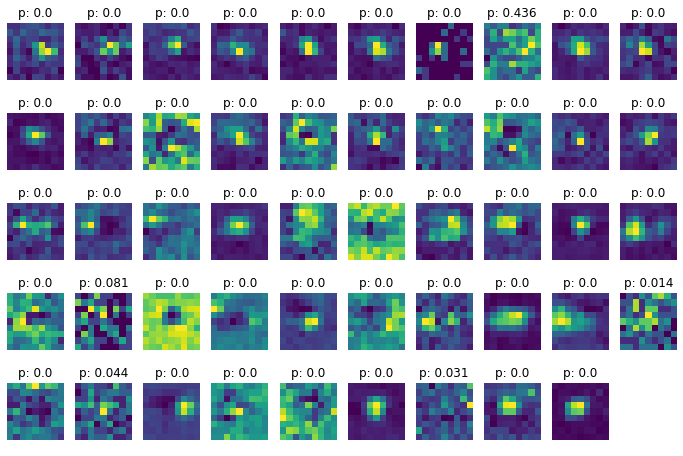

In [22]:
fig, axes = plt.subplots(int(len(area_units)/10)+1, 10)
fig.set_size_inches(12, 8)
for uind, uid in enumerate(area_units.index.values):
    unitrf = rf.get_receptive_field(uid)
    pval = rf_metrics.loc[uid]['p_value_rf']
    ax_row = int(uind/10)
    ax_col = uind%10
    axes[ax_row][ax_col].imshow(unitrf)
    axes[ax_row][ax_col].set_title(f"p: {pval}")
                         
for ax in axes.flat:
    ax.axis('off')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now we can merge our receptive field stats into the units dataframe. This will make it easy to run subsequent analysis that might require units to meet RF criteria

In [23]:
units_with_rfstats = units.merge(rf_metrics, left_index=True, right_on='unit_id')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Plotting visual responses to novel and familiar images

Image novelty depends on whether a mouse has previously encountered an image during training. Even in the novel image set, 2 images are shared with the training set and therefore familiar. Moreover, some mice train with different image sets, meaning which images are novel depends on all these factors. This can be tricky to sort out, so we have provided a convenient function that will add columns to the stimulus presentations table that indicate which image set a particular image is from (unique to `G`, unique to `H` or shared across both image sets), along with whether it was novel to the mouse during that session.

In [88]:
session_id = session.metadata['ecephys_session_id']
is_novel_image_set = ecephys_sessions_table.loc[session_id]['experience_level'] == 'Novel'

IMAGE_SET_KEY={
                'G' : ['im012_r', 'im036_r', 'im044_r', 
                    'im047_r', 'im078_r', 'im115_r'],
                'H' : ['im005_r', 'im024_r', 'im034_r', 
                    'im087_r', 'im104_r', 'im114_r'],
                'shared' : ['im083_r', 'im111_r'],
                'omitted' : 'omitted'
                }

In [89]:
def getImageNovelty(image_name):
    '''
    Function to help annotate the stimulus_presentations table
    to indicate the following info:
        1) whether a given image was:
            a) unique to the G set
            b) unique to the H set
            c) shared across G and H
            d) omitted
        2) whether the image was novel to the mouse
    
    Meant to be run on the image names of the stimulus_presentations table
    
    OUTPUT:
        Tuple indicating (image_set, image_novelty) for one 
        row of the stimulus_presentations table

    '''
    # First check that this image is one of the Natural Images used
    image_in_image_set = any([np.isin(image_name, imset) \
                              for _,imset in IMAGE_SET_KEY.items()]) 
    if not image_in_image_set:
        return np.nan, np.nan

    #Get the image set for this image
    image_set_for_this_image = [name for name, image_set in IMAGE_SET_KEY.items()\
                                if image_name in image_set][0]
    
    #Get the image novelty for this image
    if image_set_for_this_image == 'omitted':
        novelty_for_this_image = np.nan
    else:
        novelty_for_this_image = (is_novel_image_set) and \
                            (np.isin(image_set_for_this_image, ['G', 'H']))
    

    return image_set_for_this_image, novelty_for_this_image

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now let's apply that function to our stimulus_presentations table and add the new columns indicating image novelty

In [90]:
image_info = stimulus_presentations.apply(lambda row: getImageNovelty(row['image_name']), axis=1)  
stimulus_presentations['image_set'] = [i[0] for i in image_info]
stimulus_presentations['is_novel'] = [i[1] for i in image_info]

In [91]:
stimulus_presentations[120:130][['image_set', 'is_novel', 'image_name']]

,image_set,is_novel,image_name
stimulus_presentations_id,,,
120,shared,False,im111_r
121,shared,False,im111_r
122,shared,False,im111_r
123,shared,False,im111_r
124,shared,False,im111_r
125,H,True,im104_r
126,H,True,im104_r
127,H,True,im104_r
128,H,True,im104_r


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

For this (and other) analyses, organizing the data into a 3D tensor can make things much more convenient. This tensor will have shape (neurons, trial time, trials) and will store the spike counts for every neuron and trial:

<img src="resources/tensor_diagram.png"
     width="400" 
     height="500" />
     
Williams et al. (2018). Neuron, 98(6): 1099-1115

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

To make this tensor, first we'll need to get the spike times for this experiment:

In [29]:
spike_times = session.spike_times

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We've provided a couple of functions to make this tensor:

In [93]:
def makePSTH(spikes, startTimes, windowDur, binSize=0.001):
    '''
    Convenience function to compute a peri-stimulus-time histogram
    (see section 7.2.2 here: https://neuronaldynamics.epfl.ch/online/Ch7.S2.html)
    INPUTS:
        spikes: spike times in seconds for one unit
        startTimes: trial start times in seconds; the first spike count 
            bin will be aligned to these times
        windowDur: trial duration in seconds
        binSize: size of spike count bins in seconds
    OUTPUTS:
        Tuple of (PSTH, bins), where:
            PSTH gives the trial-averaged spike rate for 
                each time bin aligned to the start times;
            bins are the bin edges as defined by numpy histogram
    '''
    bins = np.arange(0,windowDur+binSize,binSize)
    counts = np.zeros(bins.size-1)
    for i,start in enumerate(startTimes):
        startInd = np.searchsorted(spikes, start)
        endInd = np.searchsorted(spikes, start+windowDur)
        counts = counts + np.histogram(spikes[startInd:endInd]-start, bins)[0]
    
    counts = counts/len(startTimes)
    return counts/binSize, bins


def make_neuron_time_trials_tensor(units, stim_table, 
                                   time_before, trial_duration,
                                   bin_size=0.001):
    '''
    Function to make a tensor with dimensions [neurons, time bins, trials] to store
    the spike counts for stimulus presentation trials. 
    INPUTS:
        units: dataframe with unit info (same form as session.units table)
        stim_table: dataframe whose indices are trial ids and containing a
            'start_time' column indicating when each trial began
        time_before: seconds to take before each start_time in the stim_table
        trial_duration: total time in seconds to take for each trial
        bin_size: bin_size in seconds used to bin spike counts 
    OUTPUTS:
        unit_tensor: tensor storing spike counts. The value in [i,j,k] 
            is the spike count for neuron i at time bin j in the kth trial.
    '''
    neuron_number = len(units)
    trial_number = len(stim_table)
    unit_tensor = np.zeros((neuron_number, int(trial_duration/bin_size), trial_number))
    
    for u_counter, (iu, unit) in enumerate(units.iterrows()):
        unit_spike_times = spike_times[iu]
        for t_counter, (it, trial) in enumerate(stim_table.iterrows()):
            trial_start = trial.start_time - time_before
            unit_tensor[u_counter, :, t_counter] = makePSTH(unit_spike_times, 
                                                            [trial_start], 
                                                            trial_duration, 
                                                            binSize=bin_size)[0]
    return unit_tensor

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now let's use these new columns to look at how image novelty impacts visual responses in VISp.

In [31]:
#Grab the portion of the stim table that describes the active behavior stimuli
task_stim_table = stimulus_presentations[stimulus_presentations['active']]

#Make tensor
time_before_flash = 1.0
trial_duration = 2.0
bin_size = 0.001
flash_stim_tensor = make_neuron_time_trials_tensor(area_units, task_stim_table, time_before_flash, trial_duration)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Let's label the dimensions on this tensor by using it to create a [DataArray](https://docs.xarray.dev/en/stable/getting-started-guide/why-xarray.html). DataArrays are like labeled numpy arrays. Creating one here will help us keep our indexing straight in further analysis. Beyond just labeling, these structures bring much of the functionality of pandas objects to N-dimensional arrays. Below, we take our (neurons, trial_time, trials) tensor and label the dimensions with **unit_ids**, **time** and **trial_ids** respectively. The labels are the `coords` of the DataArray.

In [32]:
flash_da = xr.DataArray(flash_stim_tensor, dims=("unit_id", "time", "trials"), 
                       coords={
                           "unit_id": area_units.index.values,
                           "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                           "trials": task_stim_table.index.values
                           })

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We can get the unit ids, time or trial ids from this data array directly. For example, if we want a list of all of the unit ids in this data array, we would do the following:

In [76]:
flash_da.unit_id.values

array([1061854533, 1061854546, 1061854527, 1061854524, 1061854523,
       1061854517, 1061854544, 1061854543, 1061854511, 1061854507,
       1061854506, 1061854504, 1061854503, 1061854501, 1061854496,
       1061854500, 1061854497, 1061854495, 1061854494, 1061854502,
       1061854493, 1061854492, 1061854491, 1061854489, 1061854490,
       1061854549, 1061854488, 1061854486, 1061854541, 1061854542,
       1061854485, 1061854483, 1061854484, 1061854487, 1061854479,
       1061854481, 1061854480, 1061854478, 1061854482, 1061854540,
       1061854547, 1061854476, 1061854477, 1061854474, 1061854475,
       1061854473, 1061854472, 1061854469, 1061854470], dtype=int64)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Use **sel** to index this data array and pull out data we want to use for analysis. For example, if we want to get the trial responses for unit 1061854533, we would do the following:

In [78]:
u1061854533 = flash_da.sel(unit_id=1061854533)
u1061854533.shape

(2000, 4804)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

If you'd rather work with this data as a numpy array, use **values** to convert it:

In [79]:
type(u1061854533.values)

numpy.ndarray

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Similarly, using **sel** along the time dimension, we can grab the trial responses for all neurons for only the first 100 ms of each trial:

In [82]:
first_100_ms = flash_da.sel(time=slice(0, 0.1))
first_100_ms.shape

(49, 100, 4804)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

You can also treat the xarray like a numpy array and use positional indexing. The following will return the data from the first 10 trials:

In [75]:
first_10_trials = flash_da[:, :, :10]
first_10_trials.shape

(49, 2000, 10)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now let's use our data array to find the change responses to novel and familiar images. We'll do this by: 

1) finding the trial ids for our trials of interest, and  
2) Using those ids to index the 'trials' dimension of our data array

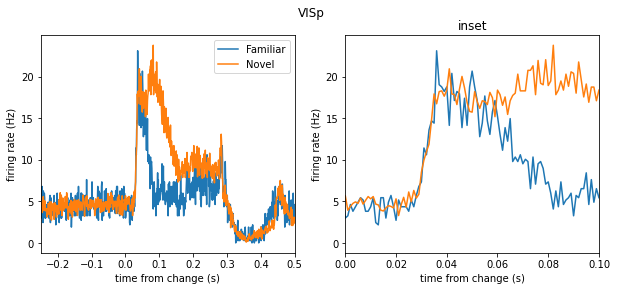

In [94]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches([10, 4])
fig.suptitle('VISp')
for isnovel in [False, True]:
    # First let's find the trial ids for the relevant change stimuli
    trial_ids = task_stim_table[(task_stim_table['is_change'])&(task_stim_table['is_novel']==isnovel)].index.values
    
    # Now let's use those trial ids to select the corresponding data from our data array
    relevant_trials = flash_da.sel(trials=trial_ids)
    
    # We can use 'mean' to conveniently average over units and trials
    mean_over_trials = relevant_trials.mean(dim=['unit_id', 'trials'])
    
    # Now plot. We're plotting twice to show two time scales.
    [ax.plot(flash_da.time, mean_over_trials) for ax in axes]

xlims = ([-0.25, 0.5], [0, 0.1])
for ax, xlim in zip(axes, xlims):
    ax.set_xlabel('time from change (s)')
    ax.set_ylabel('firing rate (Hz)')
    ax.set_xlim(xlim)
axes[1].set_title('inset')
axes[0].legend(['Familiar', 'Novel'])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Using Optotagging to Identify SST Neurons
Since this is an SST mouse, we should see putative SST+ interneurons that are activated during our optotagging protocol. Let's load the optotagging stimulus table and plot PSTHs triggered on the laser onset. For more examples and useful info about optotagging, you can check out the Visual Coding Neuropixels Optotagging notebook [here](https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html) (though note that not all the functionality in the visual coding SDK will work for this dataset).

In [34]:
opto_table = session.optotagging_table
opto_table.head()

,start_time,condition,level,stop_time,stimulus_name,duration
id,,,,,,
0,8819.44710,a single square pulse,0.78,8819.45710,pulse,0.01
1,8821.29822,half-period of a cosine wave,1.70,8822.29822,raised_cosine,1.00
2,8823.42800,half-period of a cosine wave,1.00,8824.42800,raised_cosine,1.00
3,8825.25781,half-period of a cosine wave,0.78,8826.25781,raised_cosine,1.00
4,8827.25599,a single square pulse,1.70,8827.26599,pulse,0.01


<div>
<img src="https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/42/a9/42a97aa9-910a-4e62-9b1a-62c26eab3772/opto_waveforms.png", width="700"/>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

If you check out the above table and diagram, you'll see that we use 2 different laser waveforms: a half-period cosine wave that's 1 second long and a short square pulse that's 10 ms long. We drive each at three light levels, giving us 6 total conditions. Now let's plot how cortical neurons respond to the short pulse at high power.

In [35]:
area_filter = units['structure_acronym'].str.contains('VIS')
cortical_units = units[good_unit_filter & area_filter]

#Make tensor
time_before_laser = 0.5
trial_duration = 1.5
bin_size = 0.001
opto_tensor = make_neuron_time_trials_tensor(cortical_units, opto_table, time_before_laser, trial_duration)

In [43]:
opto_da = xr.DataArray(opto_tensor, dims=("unit", "time", "trial"), 
                       coords={
                           "unit": cortical_units.index.values,
                           "time": np.arange(0, trial_duration, bin_size)-time_before_laser,
                           "trial": opto_table.index.values
                           })

In [38]:
opto_da

<xarray.DataArray (unit_id: 368, time: 1500, trials: 300)>
array([[[   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.]],

       [[   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.]],

       [[   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.]],

       ...,

       [[   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0., 1000., ..., 1000.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.]],

       [[   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.]],

       [[   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.]]])
Coordinates:
  * unit_id  (unit_id) int64 1061855316 1061855315 ... 1061853891 1061853892
  * time     (time) float64 -1.0 -0.999 -0.998 -0.997 ... 0.497 0.498 0.499
  * trials   (trials) int64 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299

(-10.0, 20.0)

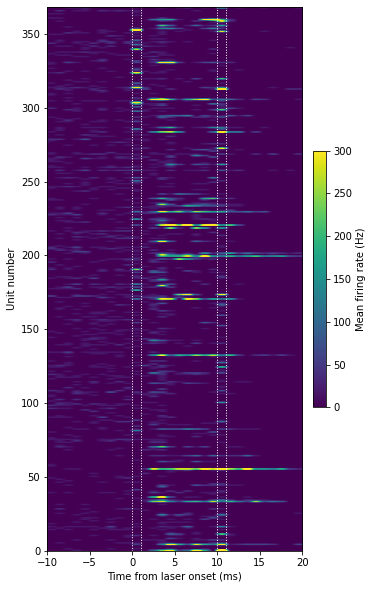

In [95]:
#Grab the short pulse at high power trials
duration = opto_table.duration.min()
level = opto_table.level.max()

sel_trials=opto_table[(opto_table['duration']==duration)&\
                      (opto_table['level']==level)].index

#Index our data array with these trials and average over trials
mean_opto_responses=opto_da.sel(time=slice(-0.05, 0.05),trial=sel_trials).mean("trial")

#Now plot a heatmap across units showing how they responded to the laser
fig,ax=plt.subplots(1,1)
fig.set_size_inches((5,10))

im=ax.imshow(mean_opto_responses,
             extent=[-50, 50, 0, len(mean_opto_responses.unit)], 
             origin='lower', aspect='auto')
min_clim_val = 0
max_clim_val = 300
im.set_clim([min_clim_val, max_clim_val])    
[ax.axvline(bound, linestyle=':', color='white', linewidth=1.0)\
     for bound in [0,1,11, 10]]
ax.set_xlabel('Time from laser onset (ms)')
ax.set_ylabel('Unit number')
cb = plt.colorbar(im,fraction=0.046, pad=0.04)
cb.set_label('Mean firing rate (Hz)')

ax.set_xlim([-10,20])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Here we can see that most units don't respond to the short laser pulse. But there is a population of ~20 units that do show elevated firing rates. Note that the activity occurring at the onset and offset of the laser (along the dotted lines) is likely artifactual and should be excluded from analysis.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Identifying Cre+ units

***copied from ecephys optotagging, could be revised***

Now that we know how to align spikes, we can start assessing which units are reliably driven by the optotagging stimulus and are likely to be Cre+.

There are a variety of ways to do this, but these are the most important things to keep in mind:

- Spikes that occur precisely at the start or end of a light pulse are likely artifactual, and need to be ignored.
- The bright blue light required for optotagging can be seen by the mouse, so any spikes that occur more than 40 ms after the stimulus onset may result from retinal input, as opposed to direct optogenetic drive.
- The rate of false negatives (Cre+ cells that are not light-driven) will vary across areas, across depths, and across sessions. We've tried our best to evenly illuminate the entire visual cortex, and to use light powers that can drive spikes throughout all cortical layers, but some variation is inevitable.

For these reasons, we've found that the 10 ms pulses are the most useful stimulus for finding true light-evoked activity. These pulses provide a long enough artifact-free window to observe light-evoked spikes, but do not last long enough to be contaminated by visually driven activity.
    
Using the DataArray we created previously, we can search for units that increase their firing rate during the 10 ms pulse:

In [96]:
# slice our data array to take the baseline period (before the laser turns on)
# then average over trials and time to get the baseline rate for each unit
baseline_rate = opto_da.sel(time=slice(-0.01,-0.002),trial=sel_trials).mean(["trial","time"])

# do the same for the period when the laser was on to get the evoked rate for each unit
evoked_rate = opto_da.sel(time=slice(0.001,0.009),trial=sel_trials).mean(["trial","time"])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Comparing the baseline and evoked rates, we can see a clear subset of units with a light-evoked increase in firing rate: 

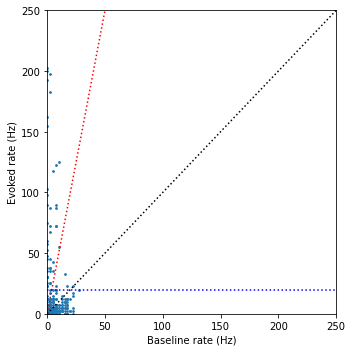

In [97]:
fig,ax=plt.subplots(1,1,figsize=(5,5))

ax.scatter(baseline_rate, evoked_rate, s=3)

axis_limit = 250
ax.plot([0,axis_limit],[0,axis_limit], ':k')
ax.plot([0,axis_limit],[0,axis_limit*5], ':r')
ax.axhline(20,color='b',linestyle=':')
ax.set_xlim([0,axis_limit])
ax.set_ylim([0,axis_limit])

ax.set_xlabel('Baseline rate (Hz)')
ax.set_ylabel('Evoked rate (Hz)')

fig.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We can select a threshold, such as 5x increase in firing rate (red line), plus an evoked rate of at least 20Hz (blue line), to find the IDs for units that are robustly driven by the light:

In [98]:
cre_pos_idx = (evoked_rate > 20) & ((evoked_rate / (baseline_rate + 1)) > 5) # add 1 to prevent divide-by-zero errors
cre_pos_units = cre_pos_idx[cre_pos_idx==True].unit

cortical_units.loc[cre_pos_units].head(3)

,PT_ratio,amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,l_ratio,...,waveform_duration,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,filtering,left_right_ccf_coordinate,probe_channel_number,probe_horizontal_position,probe_id,probe_vertical_position,structure_acronym
id,,,,,,,,,,,,,,,,,,,,,
1061855316,0.339354,158.830425,0.500000,227,600.68,6.073243,2.009925,0.468226,79.148518,0.000153,...,0.549414,7113.0,996.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,8718.0,350,59,1054059294,3520,VISrl
1061855053,0.675283,130.541385,0.500000,251,264.21,4.041208,5.054706,0.203606,100.591144,0.001928,...,0.480737,8426.0,1937.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,9891.0,342,59,1054059293,3440,VISal
1061854317,0.369872,165.241245,0.039397,333,198.12,3.398568,0.163699,0.000000,28.456214,0.043463,...,0.659296,8143.0,564.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,7679.0,336,43,1054059290,3380,VISpm


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Plotting the PSTHs from these putative optotagged units shows that they do appear to be activated by the optogenetic stimulation:

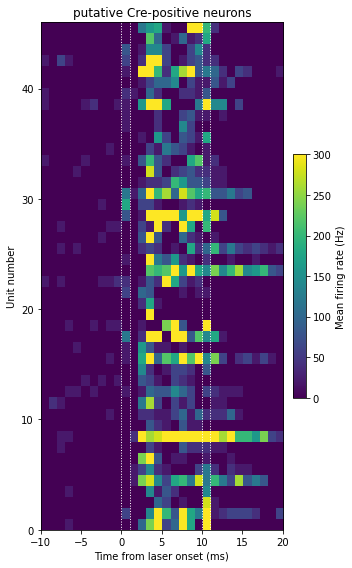

In [49]:
mean_opto_responses=opto_da.sel(time=slice(-0.05, 0.05),
                           trial=sel_trials,
                           unit=cre_pos_units).mean("trial")

fig,ax=plt.subplots(1,1)
fig.set_size_inches((5,8))

im=ax.imshow(mean_opto_responses,
             extent=[-50, 50, 0, len(mean_opto_responses.unit)], 
             origin='lower', aspect='auto')
min_clim_val = 0
max_clim_val = 300
im.set_clim([min_clim_val, max_clim_val])    
[ax.axvline(bound, linestyle=':', color='white', linewidth=1.0)\
     for bound in [0,1,11,10]]
ax.set_xlabel('Time from laser onset (ms)')
ax.set_ylabel('Unit number')
cb = plt.colorbar(im,fraction=0.046, pad=0.04)
cb.set_label('Mean firing rate (Hz)')

ax.set_xlim([-10,20])
ax.set_title('putative Cre-positive neurons')
fig.tight_layout()

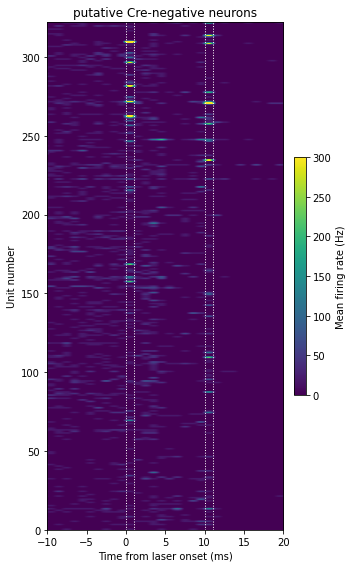

In [50]:
cre_neg_units = cre_pos_idx[cre_pos_idx==False].unit

fig,ax=plt.subplots(1,1)
fig.set_size_inches((5,8))

mean_opto_responses= opto_da.sel(time=slice(-0.05, 0.05),
                           trial=sel_trials,
                           unit=cre_neg_units).mean("trial")

im=ax.imshow(mean_opto_responses,
             extent=[-50, 50, 0, len(mean_opto_responses.unit)], 
             origin='lower', aspect='auto')
min_clim_val = 0
max_clim_val = 300
im.set_clim([min_clim_val, max_clim_val])    
[ax.axvline(bound, linestyle=':', color='white', linewidth=1.0)\
     for bound in [0,1,10,11]]
ax.set_xlabel('Time from laser onset (ms)')
ax.set_ylabel('Unit number')
cb = plt.colorbar(im,fraction=0.046, pad=0.04)
cb.set_label('Mean firing rate (Hz)')

ax.set_xlim([-10,20])
ax.set_title('putative Cre-negative neurons')
fig.tight_layout()

# How does novelty impact mouse behavior?

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Understanding the trials table
       
Let's briefly review the timing of the change detection task (`stimulus_block` 0 or the `active` portion of the stimulus table). Remember the mouse is rewarded for licking to changes in the identity of a flashing natural image. 

* Each flash is 250 ms long with 500 ms of gray screen between images (ie, 750 ms from the start of flash *n* to the start of flash *n+1*). 

* Mice are rewarded for licking within a reward window defined as 150-750 ms after an image change. 

* Licks before the change abort the trial, and a new trial begins

* 5% of flashes can be omitted with the exception of 1) the flash immediately following an omission and 2) the flash immediately preceding a change which can't be omitted.

<img src="resources/task_diagram.png"/>
     

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now let's explore the behavior trials table. This table contains lots of useful information about every trial in the change detection task.

In [53]:
trials = session.trials
trials.head()

,start_time,stop_time,initial_image_name,change_image_name,stimulus_change,change_time_no_display_delay,go,catch,lick_times,response_time,reward_time,reward_volume,hit,false_alarm,miss,correct_reject,aborted,auto_rewarded,change_frame,trial_length
trials_id,,,,,,,,,,,,,,,,,,,,
0,25.20983,26.19343,im104_r,im104_r,False,NaN,False,False,"[25.72637, 25.87602]",NaN,NaN,0.0,False,False,False,False,True,False,NaN,0.98360
1,26.71046,28.34528,im104_r,im104_r,False,NaN,False,False,[28.02817],NaN,NaN,0.0,False,False,False,False,True,False,NaN,1.63482
2,28.96234,32.73245,im104_r,im104_r,False,NaN,False,False,[32.39844],NaN,NaN,0.0,False,False,False,False,True,False,NaN,3.77011
3,33.46618,35.85175,im104_r,im104_r,False,NaN,False,False,[35.53463],NaN,NaN,0.0,False,False,False,False,True,False,NaN,2.38557
4,36.46863,39.62138,im104_r,im104_r,False,NaN,False,False,"[39.15441, 39.28716]",NaN,NaN,0.0,False,False,False,False,True,False,NaN,3.15275


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Unlike the stimulus presentations table in which every row corresponded to a visual stimulus presentation, for the behavior trials table every row corresponds to one trial of the change detection task. Here is a quick summary of the columns:

`start_time`: Experiment time when this trial began in seconds.

`stop_time`: Experiment time when this trial ended.

`initial_image_name`: Indicates which image was shown before the change (or sham change) for this trial

`change_image_name`: Indicates which image was scheduled to be the change image for this trial. Note that if the trial is aborted, a new trial will begin before this change occurs.

`stimulus_change`: Indicates whether an image change occurred for this trial. 

`change_time_no_display_delay`: Experiment time when the task-control computer commanded an image change. This change time is used to determine the response window during which a lick will trigger a reward. Note that due to display lag, this is not the time when the change image actually appears on the screen. To get this time, you need the stimulus_presentations table (more about this below).

`go`: Indicates whether this trial was a 'go' trial. To qualify as a go trial, an image change must occur and the trial cannot be autorewarded.

`catch`: Indicates whether this trial was a 'catch' trial. To qualify as a catch trial, a 'sham' change must occur during which the image identity does not change. These sham changes are drawn to match the timing distribution of real changes and can be used to calculate the false alarm rate.

`lick_times`: A list indicating when the behavioral control software recognized a lick. Note that this is not identical to the lick times from the licks dataframe, which record when the licks were registered by the lick sensor. The licks dataframe should generally be used for analysis of the licking behavior rather than these times.

`response_time`: Indicates the time when the first lick was registered by the task control software for trials that were not aborted (go or catch). NaN for aborted trials. For a more accurate measure of response time, the licks dataframe should be used.

`reward_time`: Indicates when the reward command was triggered for hit trials. NaN for other trial types. 

`reward_volume`: Indicates the volume of water dispensed as reward for this trial. 

`hit`: Indicates whether this trial was a 'hit' trial. To qualify as a hit, the trial must be a go trial during which the stimulus changed and the mouse licked within the reward window (150-750 ms after the change time).

`false_alarm`: Indicates whether this trial was a 'false alarm' trial. To qualify as a false alarm, the trial must be a catch trial during which a sham change occurred and the mouse licked during the reward window.

`miss`: To qualify as a miss trial, the trial must be a go trial during which the stimulus changed but the mouse did not lick within the response window.

`correct_reject`: To qualify as a correct reject trial, the trial must be a catch trial during which a sham change occurred and the mouse withheld licking.

`aborted`: A trial is aborted when the mouse licks before the scheduled change or sham change.

`auto_rewarded`: During autorewarded trials, the reward is automatically triggered after the change regardless of whether the mouse licked within the response window. These always come at the beginning of the session to help engage the mouse in behavior.

`change_frame`: Indicates the stimulus frame index when the change (on go trials) or sham change (on catch trials) occurred. This column can be used to link the trials table with the stimulus presentations table.

`trial_length`: Duration of the trial in seconds.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Calculating hit rates for novel and familiar images
    
Let's use the trials table to calculate the hit rates for the novel and familiar images:. First, let's take each image and calculate the hit rate for trials in which that image was the change image.

In [99]:
#First, let's annotate the trials by the novelty of their change image using the function we wrote above
image_info = trials.apply(lambda row: getImageNovelty(row['change_image_name']), axis=1)
trials['change_image_set'] = [i[0] for i in image_info]
trials['is_novel_change_image'] = [bool(i[1]) for i in image_info]

In [100]:
#let's grab the go trials since those are the ones we'll need to calculate hit rates
go_trials = trials[trials['go']]

#Now we can use a pivot table to calculate the image-wise hit rates
image_hit_rates = go_trials.pivot_table(index='change_image_name', values=['hit', 'is_novel_change_image'], 
                                        aggfunc={'hit':['mean', 'count'], 'is_novel_change_image':'first'})

#Give the columns more convenient/descriptive names
image_hit_rates.columns = image_hit_rates.columns.to_flat_index()
image_hit_rates = image_hit_rates.rename(columns={('hit', 'count'):'num_trials', 
                                ('hit', 'mean'):'hit_rate',
                                ('is_novel_change_image', 'first'): 'is_novel'})

#Finally, let's add confidence intervals on the hit rates
def get_binom_ci(row):    
    successes = np.round(row['num_trials']*row['hit_rate'], 0)
    total_trials = row['num_trials']
    proportion = row['hit_rate']
    result = binomtest(int(successes), 
                       n=int(total_trials), 
                       p=proportion)
    ci = result.proportion_ci(confidence_level=0.95)
    return [np.round(c,2) for c in ci]

cis = image_hit_rates.apply(get_binom_ci, axis=1)

image_hit_rates['confidence_interval'] = cis

colormap = cm.get_cmap('bwr')
display(image_hit_rates.style.background_gradient(cmap=colormap, subset='hit_rate'))

,num_trials,hit_rate,is_novel,confidence_interval
change_image_name,,,,
im005_r,37,0.594595,True,"[0.42, 0.75]"
im024_r,38,0.578947,True,"[0.41, 0.74]"
im034_r,36,0.666667,True,"[0.49, 0.81]"
im083_r,37,0.135135,False,"[0.05, 0.29]"
im087_r,36,0.527778,True,"[0.35, 0.7]"
im104_r,38,0.657895,True,"[0.49, 0.8]"
im111_r,37,0.135135,False,"[0.05, 0.29]"
im114_r,36,0.472222,True,"[0.3, 0.65]"


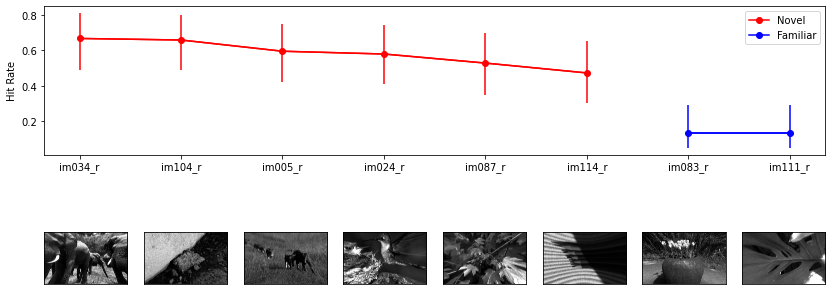

In [56]:
fig = plt.figure()
fig.set_size_inches(14, 6)
gs = GridSpec(2, 8, figure=fig)
hit_rate_ax = fig.add_subplot(gs[0, :])
colors = ['r', 'b']
image_order = []
for isnovel, color in zip([True, False], colors):
    rows = image_hit_rates[image_hit_rates['is_novel']==isnovel]
    rows = rows.sort_values('hit_rate', ascending=False)
    
    hit_rates = rows['hit_rate']
    hit_rate_ax.plot(hit_rates, color+'o-')
    errorbars = np.abs(np.vstack(rows.confidence_interval).T - hit_rates.values[None, :])
    
    hit_rate_ax.errorbar(np.arange(len(image_order), len(image_order) + len(hit_rates)), 
                         hit_rates, 
                        yerr=errorbars,
                        color=color)
    
    image_order.extend(rows.index.values)
    
hit_rate_ax.set_ylabel('Hit Rate')
hit_rate_ax.legend(['Novel', 'Familiar'])

    
for ind, im in enumerate(image_order):
    im_ax = fig.add_subplot(gs[1, ind])
    im_ax.imshow(session.stimulus_templates['warped'][im], cmap='gray')
    im_ax.axes.xaxis.set_visible(False)
    im_ax.axes.yaxis.set_visible(False)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Getting pupil, running and licking data
    
Now let's grab the licking, running and pupil tracking data for this session and align it to the behavior.

In [57]:
#Let's get the three behavior data frames
eye_tracking = session.eye_tracking
running_speed = session.running_speed
licks = session.licks

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

**Eye tracking dataframe**: One entry containing ellipse fit parameters for the eye, pupil and corneal reflection for every frame of the eye tracking video stream.

In [57]:
eye_tracking.head()

,timestamps,cr_area,eye_area,pupil_area,likely_blink,pupil_area_raw,cr_area_raw,eye_area_raw,cr_center_x,cr_center_y,...,eye_center_x,eye_center_y,eye_width,eye_height,eye_phi,pupil_center_x,pupil_center_y,pupil_width,pupil_height,pupil_phi
frame,,,,,,,,,,,,,,,,,,,,,
0,1.36447,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.38113,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.39780,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.41446,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.43113,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

There seem to be several rows for which there are no valid data. We can use the 'likely_blink' column to filter these out.

In [59]:
eye_tracking_noblinks = eye_tracking[~eye_tracking['likely_blink']]
eye_tracking_noblinks.head()

,timestamps,cr_area,eye_area,pupil_area,likely_blink,pupil_area_raw,cr_area_raw,eye_area_raw,cr_center_x,cr_center_y,...,eye_center_x,eye_center_y,eye_width,eye_height,eye_phi,pupil_center_x,pupil_center_y,pupil_width,pupil_height,pupil_phi
frame,,,,,,,,,,,,,,,,,,,,,
18,1.68114,124.496878,80242.785195,16745.289582,False,16745.289582,124.496878,80242.785195,319.022720,250.040195,...,299.845062,243.459515,170.130669,150.132084,-0.117730,314.825135,228.266183,73.008159,68.378221,0.394571
19,1.69781,123.635359,79751.038277,16714.291578,False,16714.291578,123.635359,79751.038277,319.495616,250.370579,...,300.310986,243.292274,169.847920,149.460434,-0.097911,314.511686,228.197930,72.940553,67.705300,0.428495
20,1.71446,126.786150,80047.938510,17011.966515,False,17011.966515,126.786150,80047.938510,319.370721,250.517232,...,300.324160,243.947900,169.934887,149.940078,-0.087952,314.455601,228.205356,73.587208,68.166068,0.423260
21,1.73113,125.499820,80455.812438,16980.668668,False,16980.668668,125.499820,80455.812438,319.460923,250.304993,...,300.694063,243.883540,170.484281,150.218427,-0.088550,314.077673,228.185581,73.519485,67.545130,0.460218
22,1.74780,125.322643,80325.325277,17062.517640,False,17062.517640,125.322643,80325.325277,318.788323,249.441627,...,300.010309,243.120696,170.311250,150.127165,-0.108505,314.283247,227.043133,73.696459,67.493397,0.442226


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

**Running dataframe**: One entry for each read of the analog input line monitoring the encoder voltage, polled at ~60 Hz.

In [60]:
running_speed.head()

,timestamps,speed
0,24.21123,-0.025043
1,24.22482,11.007905
2,24.24165,21.528507
3,24.25821,31.042079
4,24.27497,39.117779


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

**Licking dataframe**: One entry for every detected lick onset time,

In [61]:
licks.head()

,timestamps,frame
0,25.72309,91
1,25.85921,100
2,28.01198,229
3,32.39186,491
4,35.52050,679


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Aligning behavioral data to task events

Now let's take a look at running, licking and pupil area for one rewarded trial

C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_44304\900331870.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior_presentations.loc[:,'omitted'] = behavior_presentations.loc[:,'omitted'].astype('bool')


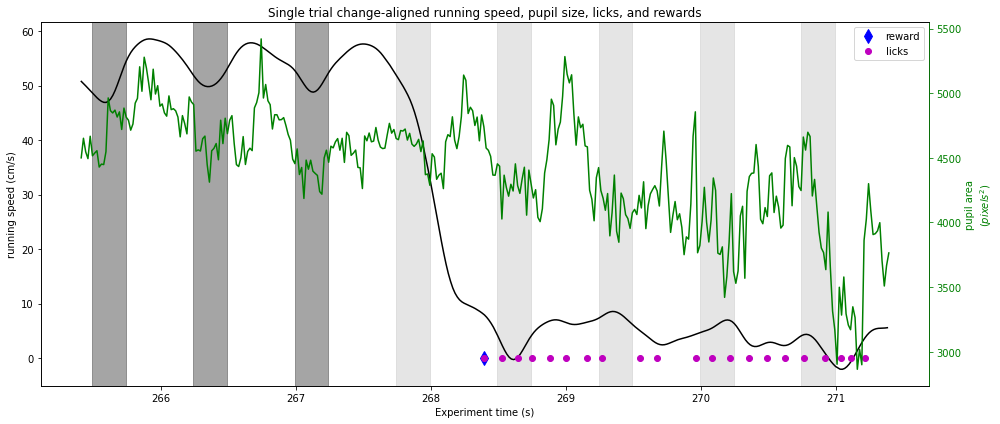

In [62]:
time_before = 3.0 #how much time to plot before the reward
time_after = 3.0 #how much time to plot after the reward
reward_time = session.rewards.iloc[10]['timestamps'] #get the time of the 10th reward

#Get running data aligned to this reward
trial_running = running_speed.query('timestamps >= {} and timestamps <= {} '.
                                    format(reward_time-time_before, reward_time+time_after))

#Get pupil data aligned to this reward
trial_pupil_area = eye_tracking_noblinks.query('timestamps >= {} and timestamps <= {} '.
                                    format(reward_time-time_before, reward_time+time_after))

#Get stimulus presentations around this reward
behavior_presentations = stimulus_presentations[stimulus_presentations['active']]
behavior_presentations.loc[:,'omitted'] = behavior_presentations.loc[:,'omitted'].astype('bool')
trial_stimuli = behavior_presentations.query('stop_time >= {} and start_time <= {} and not omitted'.
                                             format(reward_time-time_before, reward_time+time_after))

#Get licking aligned to this reward
trial_licking = licks.query('timestamps >= {} and timestamps <= {} '.
                                    format(reward_time-time_before, reward_time+time_after))


#Plot running, pupil area and licks
fig, axr = plt.subplots()
fig.set_size_inches(14,6)
axr.plot(trial_running['timestamps'], trial_running['speed'], 'k')
axp = axr.twinx()
axp.plot(trial_pupil_area['timestamps'], trial_pupil_area['pupil_area'], 'g')
rew_handle, = axr.plot(reward_time, 0, 'db', markersize=10)
lick_handle, = axr.plot(trial_licking['timestamps'], np.zeros(len(trial_licking['timestamps'])), 'mo')
axr.legend([rew_handle, lick_handle], ['reward', 'licks'])

axr.set_ylabel('running speed (cm/s)')
axp.set_ylabel('pupil area\n$(pixels^2)$')
axr.set_xlabel('Experiment time (s)')

axp.yaxis.label.set_color('g')
axp.spines['right'].set_color('g')
axp.tick_params(axis='y', colors='g')

#Plot the image flashes as grey bars. 
colors = ['0.3', '0.8']
stimulus_colors = {stim: c for stim,c in zip(trial_stimuli['image_name'].unique(), colors)}
for idx, stimulus in trial_stimuli.iterrows():
    axr.axvspan(stimulus['start_time'], stimulus['stop_time'], color=stimulus_colors[stimulus['image_name']], alpha=0.5)
    
axr.set_title('Single trial change-aligned running speed, pupil size, licks, and rewards')

fig.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Behavior aligned to novel vs. familiar changes

In [63]:
## where the data consists of values at various timepoints, i.e. running, pupil area
def align_continuous_data_to_events(event_times,data,data_timestamps,start=-5,end=5,binsize=1/60):
    
    #define bins
    bins=np.arange(start,end+binsize,binsize)
    n_points=(len(bins)-1)
    
    #pre-allocate array
    data_matrix=np.zeros((len(event_times),len(bins)-1))
    
    for ii,rr in enumerate(event_times):
        start_ind=np.where(data_timestamps>=rr)[0][0]
        
        #get the data aligned to this trial
        if ((start_ind-n_points/2)>=0) & ((start_ind+n_points/2)<len(data)):
            data_matrix[ii,:]=data[np.round(start_ind-n_points/2).astype('int'):
                                   np.round(start_ind+n_points/2).astype('int')]
        else:
            data_matrix[ii,:]=np.nan
    
    da = xr.DataArray(
        data_matrix, 
        dims=("trial_id", "time"), 
        coords={"trial_id": event_times.index.values, 
                "time": bins[:-1]} 
    )
    
    return da

In [64]:
## where the data consists of just timestamps i.e. spikes, licking
def align_discrete_data_to_events(event_times,data_timestamps,start=-5,end=5,binsize=3/60):
    
    #define bins
    bins=np.arange(start,end+binsize,binsize)
    bin_centers=bins[:-1]+(binsize/2)
    n_points=(len(bins)-1)
    
    #pre-allocate array
    data_matrix=np.zeros((len(event_times),len(bins)-1))
    
    for ii,rr in enumerate(event_times):
        start_ind=np.where(data_timestamps>=rr)[0][0]
        
        #get the behavior data aligned to this trial          
        trial_data = data_timestamps[(data_timestamps>=(rr-5))&(data_timestamps<(rr+5))]
        trial_data_hist, edges = np.histogram(trial_data.values-rr,bins)
        data_matrix[ii,:] = trial_data_hist/(3/60)
    
    da = xr.DataArray(
        data_matrix, 
        dims=("trial_id", "time"), 
        coords={"trial_id": event_times.index.values, 
                "time": bin_centers} 
    )
    
    return da

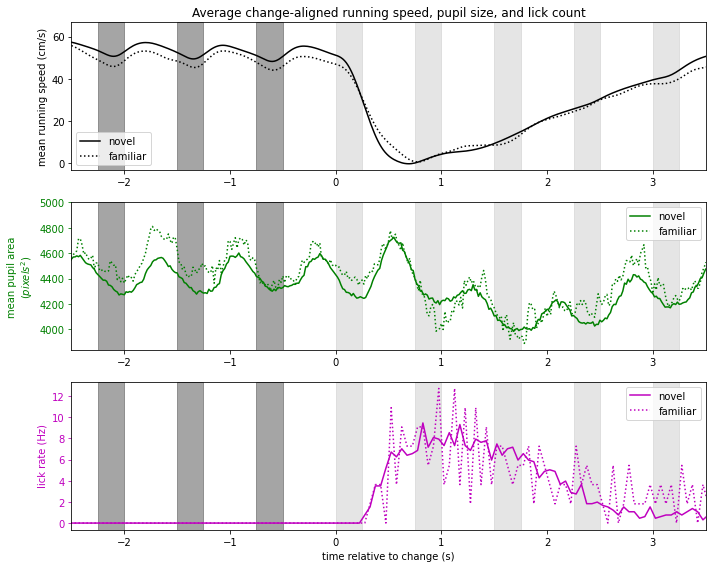

In [65]:
#Align pupil, running, licking to novel vs familiar changes

#find the times of rewarded image changes
novel_rewarded_stimulus_times = stimulus_presentations.query(
    'rewarded == True & active == True & is_novel == 1')['start_time']

familiar_rewarded_stimulus_times = stimulus_presentations.query(
    'rewarded == True & active == True & is_novel == 0')['start_time']

novel_running_data=align_continuous_data_to_events(
    novel_rewarded_stimulus_times,
    running_speed['speed'],
    running_speed['timestamps']
)

novel_pupil_data=align_continuous_data_to_events(
    novel_rewarded_stimulus_times,
    eye_tracking_noblinks['pupil_area'],
    eye_tracking_noblinks['timestamps']
)

novel_lick_data=align_discrete_data_to_events(
    novel_rewarded_stimulus_times,
    licks['timestamps']
)

familiar_running_data=align_continuous_data_to_events(
    familiar_rewarded_stimulus_times,
    running_speed['speed'],
    running_speed['timestamps']
)

familiar_pupil_data=align_continuous_data_to_events(
    familiar_rewarded_stimulus_times,
    eye_tracking_noblinks['pupil_area'],
    eye_tracking_noblinks['timestamps']
)

familiar_lick_data=align_discrete_data_to_events(
    familiar_rewarded_stimulus_times,
    licks['timestamps']
)

fig,axr=plt.subplots(3,1)
fig.set_size_inches(10,8)

for xx in range(0,3):
    
    if xx==0:
        axr[xx].plot(novel_running_data.time,np.nanmean(novel_running_data,0),color='k')
        axr[xx].plot(familiar_running_data.time,np.nanmean(familiar_running_data,0),'k:')
        axr[xx].set_ylabel('mean running speed (cm/s)')
    elif xx==1:
        axr[xx].plot(novel_pupil_data.time,np.nanmean(novel_pupil_data,0),color='g')
        axr[xx].plot(familiar_pupil_data.time,np.nanmean(familiar_pupil_data,0),'g:')
        axr[xx].yaxis.label.set_color('g')
        axr[xx].tick_params(axis='y', colors='g')
        axr[xx].set_ylabel('mean pupil area\n$(pixels^2)$')
    elif xx==2:
        axr[xx].plot(novel_lick_data.time,np.nanmean(novel_lick_data,0),color='m')
        axr[xx].plot(familiar_lick_data.time,np.nanmean(familiar_lick_data,0),'m:')
        axr[xx].set_xlabel('time relative to change (s)')
        axr[xx].yaxis.label.set_color('m')
        axr[xx].yaxis.label.set_color('m')
        axr[xx].tick_params(axis='y', colors='m')
        axr[xx].set_ylabel('lick rate (Hz)')
    
    axr[xx].legend(['novel','familiar'])
    axr[xx].set_xlim([-2.5,3.5])
    
    #Plot the image flashes as grey bars. 
    colors = ['0.3', '0.8']
    stimulus_colors = {stim: c for stim,c in zip(trial_stimuli['image_name'].unique(), colors)}
    change_time=trial_stimuli['start_time'][trial_stimuli['is_change']==True]
    for idx, stimulus in trial_stimuli.iterrows():
        axr[xx].axvspan(stimulus['start_time']-change_time.values[0], stimulus['stop_time']-change_time.values[0], 
                    color=stimulus_colors[stimulus['image_name']], alpha=0.5)

axr[0].set_title('Average change-aligned running speed, pupil size, and lick count')
    
fig.tight_layout()

### exercise ideas:

(still need to think of some easier ones; these are all the same-ish difficulty)

1: compare responses during active and passive epochs across brain regions. Which are most modulated?

2: compare responses of different cell types (SST, RS, FS) defined by optotagging and waveform features

3: compare rate of adaptation to repeated flashes of same stimulus across areas

?